In [1]:
from collections import Counter
from functools import partial
import copy

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import spacy
import seaborn as sns
import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split

sns.set(rc={'figure.figsize':(10,10)})
SEED = 42

In [2]:
def set_seed(seed):
    """
    Fixa semente aleatória para garantir que os resultados possam ser reproduzidos
    """
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    np.random.seed(seed)
    random.seed(seed)
    
def tokenize (text, tok):
    return [token.text for token in tok.tokenizer(text)]

def encode_sentence(text, vocab2index, tok, N=1000):
    # tokenize text
    tokenized = tokenize(text, tok)
    # generate vector of size N filled with zeros
    encoded = np.zeros(N, dtype=int)
    # get encode for each word in text, if word not in vocab2index return UNK encode = 1
    enc1 = np.array([vocab2index.get(word, vocab2index["UNK"]) for word in tokenized])
    # sentence length
    length = min(N, len(enc1))
    # if the sentence length is less than N, the extra spaces will be filled with zeros.
    encoded[:length] = enc1[:length]
    return encoded, length

In [3]:
#AMANDA
class load_data(torch.utils.data.Dataset):
    """
    Classe auxiliar para utilização do DataLoader
    """
    def __init__(self, X, Y):
        self.X = X      
        self.y = Y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        # word_embedding, label, document length, city, doc_id, ['num_pages_ratio', 'num_termos_antes_preproc_ratio', 'meta-class_vec']
        self.Z = torch.from_numpy(np.append(self.X[idx][2:-2].astype(np.float32), self.X[idx][-2]).astype(np.float32))
        return torch.from_numpy(self.X[idx][-1][0].astype(np.int32)), self.y[idx], self.X[idx][-1][1], self.X[idx][0], self.X[idx][1], self.Z

In [4]:
def split_data(df_data, fold):
    #AMANDA
    X = df_data.loc[df_data['fold'] == fold, ["city", "doc_id", 'num_pages_ratio', 'num_termos_antes_preproc_ratio', 'meta-class_vec', "four_pages_encoded"]].values
    y = df_data.loc[df_data['fold'] == fold, 'label_int'].values
    
    return X, y

def encode_data(df_data, config):
    tok = spacy.load('pt_core_news_sm')

    # count frequency of each word    
    counts = Counter()
    for index, row in df_data.loc[df_data['fold']=="train"].iterrows():
        counts.update(tokenize(row['four_pages_processed'], tok))

    #creating vocabulary
    vocab2index = {"":0, "UNK":1}
    words = ["", "UNK"]
    for word in counts:
        vocab2index[word] = len(words)
        words.append(word)
        
    vocab_size = len(words)

    # encoding
    df_data['four_pages_encoded'] = None
    df_data.loc[df_data['fold'] == 'train','four_pages_encoded'] = df_data.loc[df_data['fold'] == 'train','four_pages_processed'].apply(lambda x: np.array(encode_sentence(x,vocab2index, tok, config["num_terms"] )))
    df_data.loc[df_data['fold'] == 'val','four_pages_encoded'] = df_data.loc[df_data['fold'] == 'val','four_pages_processed'].apply(lambda x: np.array(encode_sentence(x,vocab2index, tok, config["num_terms"] )))
    df_data.loc[df_data['fold'] == 'test','four_pages_encoded'] = df_data.loc[df_data['fold'] == 'test','four_pages_processed'].apply(lambda x: np.array(encode_sentence(x,vocab2index, tok, config["num_terms"] )))
    
    return df_data, vocab_size, vocab2index

In [5]:
def calculate_metrics(y_true, y_pred):
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    acc = accuracy_score(y_true, y_pred)
    
    return acc, f1_macro, f1_weighted

In [6]:
import torch
from torch import nn
from typing import List
import os
import json



class LSTM(nn.Module):
    """
    Bidirectional LSTM running over word embeddings.
    """
    def __init__(self, embedding_matrix, word_embedding_dimension: int, hidden_dim: int, num_layers: int = 1, num_classes: int = 13, vocab_size: int = 0, dropout: float = 0, bidirectional: bool = True, num_stats: int = 6):
        nn.Module.__init__(self)
        self.config_keys = ['word_embedding_dimension', 'hidden_dim', 'num_layers', 'dropout', 'bidirectional']
        self.word_embedding_dimension = word_embedding_dimension
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.dropout = dropout
        self.bidirectional = bidirectional
        self.vocab_size = vocab_size

        self.embeddings_dimension = hidden_dim
        if self.bidirectional:
            self.embeddings_dimension *= 2
            
        self.embeddings = nn.Embedding(vocab_size, word_embedding_dimension, padding_idx=0)
        self.embeddings.weight=nn.Parameter(torch.tensor(embedding_matrix,dtype=torch.float32))
        self.embeddings.weight.requires_grad=False
        self.dropout = nn.Dropout(dropout)
        self.encoder = nn.LSTM(word_embedding_dimension, int(word_embedding_dimension/2), num_layers=num_layers, dropout=dropout, bidirectional=bidirectional, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        # aumenta uma dimensão
        self.linear = nn.Linear(int(word_embedding_dimension/2)+num_stats, num_classes)

    def forward(self, features, doc_stats):
        x = self.embeddings(features)
        x = self.dropout(x)
        out_pack, (ht, ct) = self.encoder(x)
        ht[-1] = self.dropout(ht[-1])
        #doc_stats = doc_stats.view([doc_stats.shape[0],1])
        x = torch.cat((ht[-1], doc_stats), 1)
        #print(x.shape)
        out = self.linear(x)
        return out

    def get_word_embedding_dimension(self) -> int:
        return self.embeddings_dimension

    def tokenize(self, text: str) -> List[int]:
        raise NotImplementedError()

    def save(self, output_path: str):
        with open(os.path.join(output_path, 'lstm_config.json'), 'w') as fOut:
            json.dump(self.get_config_dict(), fOut, indent=2)

        torch.save(self.state_dict(), os.path.join(output_path, 'pytorch_model.bin'))

    def get_config_dict(self):
        return {key: self.__dict__[key] for key in self.config_keys}

    @staticmethod
    def load(input_path: str):
        with open(os.path.join(input_path, 'lstm_config.json'), 'r') as fIn:
            config = json.load(fIn)

        weights = torch.load(os.path.join(input_path, 'pytorch_model.bin'))
        model = LSTM(**config)
        model.load_state_dict(weights)
        return model

In [7]:
def data_load(config, df_data):
    # Split data
    X_train, y_train = split_data(df_data, "train")
    X_val, y_val = split_data(df_data, "val")
    X_test, y_test = split_data(df_data, "test")
    
    # Load dataset
    train_set = load_data(X_train, y_train)
    val_set = load_data(X_val, y_val)
    test_set = load_data(X_test, y_test)
    
    data_loaders = dict()

    data_loaders["train"] = torch.utils.data.DataLoader(
        train_set,
        batch_size=int(config["batch_size"]),
        shuffle=True,
        num_workers=8)
    data_loaders["val"] = torch.utils.data.DataLoader(
        val_set,
        batch_size=int(config["batch_size"]),
        shuffle=False,
        num_workers=8)
    data_loaders["test"] = torch.utils.data.DataLoader(
        test_set,
        batch_size=int(config["batch_size"]),
        shuffle=False,
        num_workers=8)
    
    return data_loaders

In [8]:
def plot_confusion_matrix(y_pred, y_true, fold, labels_dict):
    ticks = copy.deepcopy(y_pred)
    ticks.extend(y_true)
    print(set(ticks))
    print(labels_dict)
    ticks = [labels_dict[tick] for tick in set(ticks)]
    
    cm = sns.heatmap(
        confusion_matrix(y_true, y_pred,normalize="true"),
        annot=True,
        center=0,
        vmin=0,
        vmax=1,
        square=True,
        fmt=".2f",
        xticklabels=ticks,
        yticklabels=ticks,
    )
    plt.yticks(rotation=0)
    img_name = "Confusion Matrix - {}".format(fold)
    plt.title(img_name)
    plt.savefig("./lstm_data/results/setup_sandbox/img/confusion_matrix_sandbox_{}.png".format(fold))
    plt.show()

In [9]:
def train_model(config, checkpoint_dir=None, data_loaders=None, embedding_matrix = None):
    if not config["patience"]:
        config["patience"] = config["num_epochs"]
    patience_counter = 0
    
    train_loader = data_loaders["train"]
    val_loader = data_loaders["val"]
    
    model = LSTM(
        embedding_matrix = embedding_matrix,
        word_embedding_dimension = config["embedding_dim"], 
        hidden_dim = config["embedding_dim"], 
        num_classes = config["num_classes"], 
        vocab_size = config["vocab_size"],
        num_layers = config["num_layers"], 
        dropout = config["dropout"], 
        bidirectional = True
    )
        
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
    model.to(device)
    
    best_model = copy.deepcopy(model)
    best_loss = float("inf")
    #best_macro = 0.0

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config["lr"])

    """if checkpoint_dir:
        model_state, optimizer_state = torch.load(
            os.path.join(checkpoint_dir, "checkpoint"))
        model.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)"""
        
    for epoch in range(config["num_epochs"]):  # loop over the dataset multiple times
        print("="*20,"Epoch: {}".format(epoch+1), "="*20)
        model.train()
        training_loss = 0.0
        epoch_steps = 0
        y_pred = []
        y_true = []
        for i, data in enumerate(tqdm.tqdm_notebook(train_loader), 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels, sentence_length, _, _, doc_stats = data
            inputs, labels, doc_stats = inputs.long().to(device), labels.long().to(device), doc_stats.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs, doc_stats)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            epoch_steps += 1
            training_loss += loss.cpu().detach().numpy()
            
            _, predicted = torch.max(outputs.data, 1)
            
            y_pred.extend(predicted.cpu().tolist())
            y_true.extend(labels.cpu().tolist())
            
        train_metrics = [(training_loss/epoch_steps)]
        train_metrics.extend(calculate_metrics(y_true, y_pred))
        
        print("Train:\n loss %.3f, accuracy %.3f, F1-Macro %.3f, F1-Weighted %.3f" % (
        train_metrics[0], train_metrics[1], train_metrics[2], train_metrics[3]))

        val_metrics = eval_model(model, val_loader, device=device)
        print("Val:\n loss %.3f, accuracy %.3f, F1-Macro %.3f, F1-Weighted %.3f \n" % (
        val_metrics[0], val_metrics[1], val_metrics[2], val_metrics[3]))
        
        #if val_metrics[2] > best_macro:
        if val_metrics[0] < best_loss - 0.001:
            best_loss = val_metrics[0]
            best_model = copy.deepcopy(model)
            best_macro = val_metrics[2]
            patience_counter = 0
            #AMANDA
            path = os.path.join(checkpoint_dir, "model_setup_sandbox.pth")
            torch.save((model.state_dict(), optimizer.state_dict()), path)
        else:
            patience_counter += 1
            if patience_counter >= config["patience"]:
                print("Model training was stopped early")
                break
            
    print("Finished Training")
    return best_model

In [10]:
def eval_model(model, loader, fold=None, labels_dict = None, device="cpu"):
    model.eval()
    criterion = nn.CrossEntropyLoss()

    steps = 0
    sum_loss = 0.0
    y_true = []
    y_pred = []
    cities = []
    docs = []
    with torch.no_grad():
        for data in tqdm.tqdm_notebook(loader):
            #AMANDA
            if fold:
                inputs, labels, sentence_length, city, doc_id, doc_stats = data
                cities.extend(city)
                docs.extend(doc_id)
            else:
                inputs, labels, sentence_length, _, _, doc_stats = data
            inputs, labels, doc_stats = inputs.long().to(device), labels.long().to(device), doc_stats.to(device)
            outputs = model(inputs, doc_stats)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            
            steps += 1
            sum_loss += loss.cpu().detach().numpy()
            
            y_pred.extend(predicted.cpu().tolist())
            y_true.extend(labels.cpu().tolist())
    
    metrics = [(sum_loss/steps)]
    metrics.extend(calculate_metrics(y_true, y_pred))
    if fold:
        df_predictions = pd.DataFrame({"doc_id": docs, "city": cities, "label": y_true, "pred": y_pred})
        df_predictions['fold'] = fold
        df_predictions.to_csv("./lstm_data/results/setup_sandbox/setup_sandbox_{}.csv".format(fold, index=False))
        # Plot confusion matrix
        plot_confusion_matrix(y_pred, y_true, fold, labels_dict)
    return metrics

In [11]:
def create_embedding_matrix(word_index,dimension):
    df_emb = pd.read_csv("./lstm_data/embeddings/modelo_w2v_vec600_wd10_ct5_tec1.txt", header=None, sep = " ", index_col=0,skiprows=1)

    embedding_dict = {key: val.values for key, val in df_emb.T.items()}
    embedding_matrix=np.zeros((len(word_index)+1,dimension))

    for word,index in word_index.items():
        if word in embedding_dict:
            embedding_matrix[index]=embedding_dict[word]
    return embedding_matrix

In [12]:
from sklearn.model_selection import train_test_split
def split_data_by_city_and_class(df):
    # criamos uma nova classe cidade+label
    df["multi_label"] = df["label"]+"_"+df["city"]
    # verificamos se existem classes que aparecem apenas 1 vez em algum município
    df_multilabel_size = df.groupby("multi_label").size().reset_index(name="size")
    # selecionamos esses casos
    unique_classes = df_multilabel_size.loc[df_multilabel_size["size"]==1, 'multi_label'].values
    # definimos todos como treino
    df["fold"] = "train"
    # "classes unicas" vão pro conjunto de validação
    df.loc[(df["multi_label"].isin(unique_classes))& (df["fold"]=="train"), "fold"] = "val"

    num_docs = df.shape[0]
    test_size = round(0.1*num_docs)
    val_size = round(0.2*num_docs)

    # fazemos o split considerando a multi_label
    train, test, _, _ = train_test_split(
            df.loc[df["fold"] == "train"],
            df.loc[df["fold"] == "train","multi_label"], 
        stratify = df.loc[df["fold"] == "train","multi_label"],
        test_size = test_size, 
        random_state=SEED)
    # define os docs que vão pra validação
    df.loc[test.index, "fold"] = "test"

    # fazemos o split considerando a multi_label
    train, val, _, _ = train_test_split(
            df.loc[df["fold"] == "train"],
            df.loc[df["fold"] == "train","multi_label"], 
        stratify = df.loc[df["fold"] == "train","multi_label"],
        test_size = val_size, 
        random_state=SEED)
    # define os docs que vão pra validação
    df.loc[val.index, "fold"] = "val"
    
    return df

def calculate_doc_statistics(df):
    df_avg = df.loc[df['fold']=='train'].groupby('city').agg({'num_pages':'mean', 'num_termos_antes_preproc':'mean'}).reset_index()
    df = pd.merge(df, df_avg, on='city', suffixes=('', '_avg'))
    df['num_pages_ratio'] = df['num_pages'] / df['num_pages_avg']
    df['num_termos_antes_preproc_ratio'] = df['num_termos_antes_preproc'] / df['num_termos_antes_preproc_avg']
    return df

def meta_class_to_vec(df):
    # v1
    df['meta-class_vec'] = df['meta-class'].map({"ATA":[1,0,0,0], "EDITAL":[0,1,0,0], "HOMOLOG":[0,0,1,0], "OUTROS":[0,0,0,1]})
    # v2
    #df['meta-class_vec'] = df['meta-class'].map({"ATA":[0,0], "EDITAL":[0,1], "HOMOLOG":[1,0], "OUTROS":[1,1]})
    return df

/dados01/workspace/ufmg.f01dcc/py37/lib/python3.7/site-packages/ipykernel_launcher.py:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/dados01/workspace/ufmg.f01dcc/py37/lib/python3.7/site-packages/ipykernel_launcher.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/dados01/workspace/ufmg.f01dcc/py37/lib/python3.7/site-packages/ipykernel_launcher.py:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do

==================== Epoch: 1 ====================


/dados01/workspace/ufmg.f01dcc/py37/lib/python3.7/site-packages/ipykernel_launcher.py:45: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/165 [00:00<?, ?it/s]

Train:
 loss 0.692, accuracy 0.802, F1-Macro 0.652, F1-Weighted 0.787


/dados01/workspace/ufmg.f01dcc/py37/lib/python3.7/site-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


  0%|          | 0/48 [00:00<?, ?it/s]

Val:
 loss 0.314, accuracy 0.924, F1-Macro 0.782, F1-Weighted 0.908 

==================== Epoch: 2 ====================


/dados01/workspace/ufmg.f01dcc/py37/lib/python3.7/site-packages/ipykernel_launcher.py:45: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/165 [00:00<?, ?it/s]

Train:
 loss 0.278, accuracy 0.930, F1-Macro 0.839, F1-Weighted 0.922


/dados01/workspace/ufmg.f01dcc/py37/lib/python3.7/site-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


  0%|          | 0/48 [00:00<?, ?it/s]

Val:
 loss 0.319, accuracy 0.924, F1-Macro 0.845, F1-Weighted 0.917 

Finished Training
==================== BEST MODEL ====================


/dados01/workspace/ufmg.f01dcc/py37/lib/python3.7/site-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


  0%|          | 0/165 [00:00<?, ?it/s]

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}
{0: 'ata dispensa licitacao', 1: 'outras atas', 2: 'ata pregao presencial', 3: 'ata registro precos', 4: 'edital', 5: 'homologacao adjudicacao', 6: 'errata', 7: 'aditamento', 8: 'outros', 9: 'aviso', 10: 'contrato', 11: 'publicacao diario oficial', 12: 'ratificacao'}


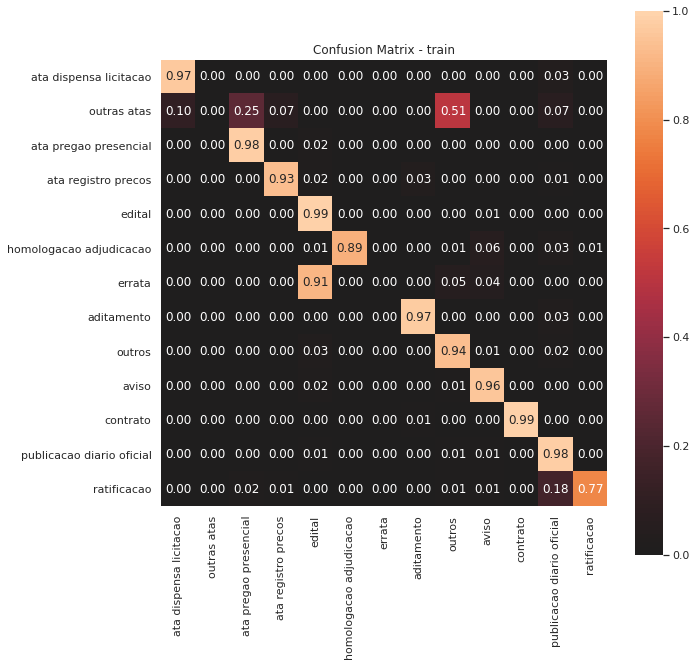

Train:
 loss 0.263, accuracy 0.929, F1-Macro 0.782, F1-Weighted 0.914


/dados01/workspace/ufmg.f01dcc/py37/lib/python3.7/site-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


  0%|          | 0/48 [00:00<?, ?it/s]

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}
{0: 'ata dispensa licitacao', 1: 'outras atas', 2: 'ata pregao presencial', 3: 'ata registro precos', 4: 'edital', 5: 'homologacao adjudicacao', 6: 'errata', 7: 'aditamento', 8: 'outros', 9: 'aviso', 10: 'contrato', 11: 'publicacao diario oficial', 12: 'ratificacao'}


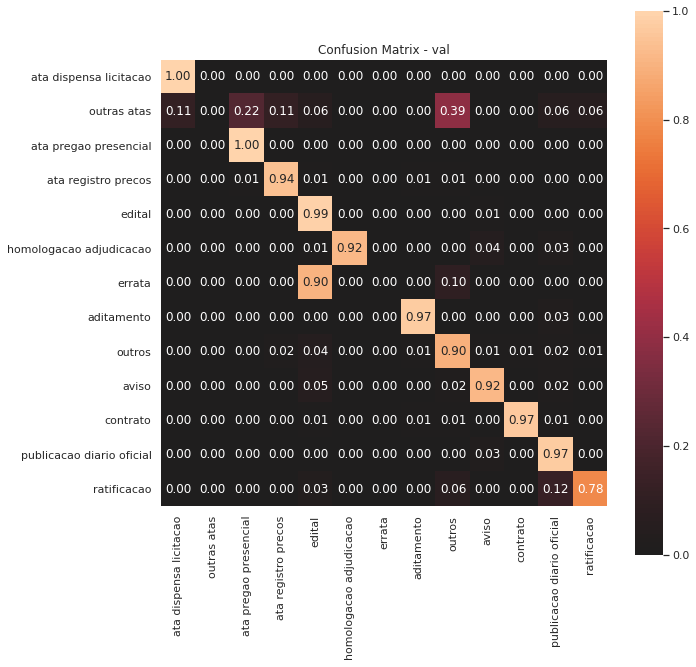

Val:
 loss 0.314, accuracy 0.924, F1-Macro 0.782, F1-Weighted 0.908


/dados01/workspace/ufmg.f01dcc/py37/lib/python3.7/site-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


  0%|          | 0/24 [00:00<?, ?it/s]

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}
{0: 'ata dispensa licitacao', 1: 'outras atas', 2: 'ata pregao presencial', 3: 'ata registro precos', 4: 'edital', 5: 'homologacao adjudicacao', 6: 'errata', 7: 'aditamento', 8: 'outros', 9: 'aviso', 10: 'contrato', 11: 'publicacao diario oficial', 12: 'ratificacao'}


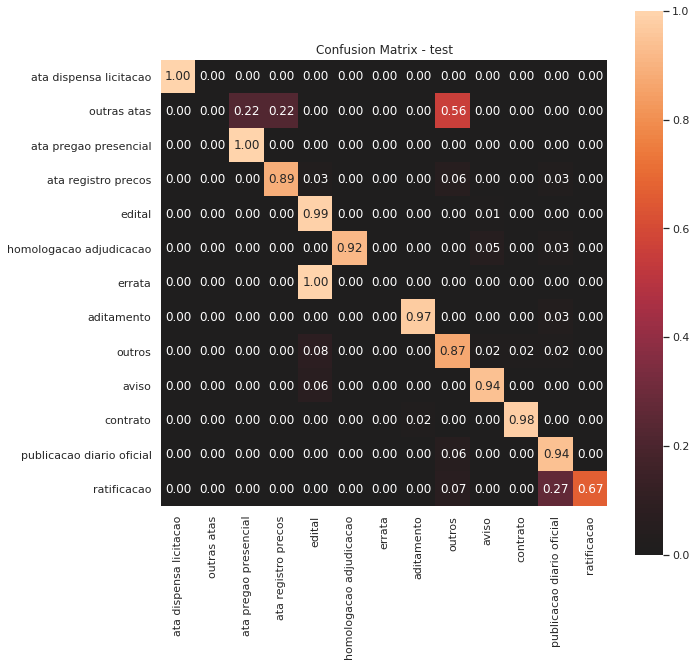

Test:
 loss 0.294, accuracy 0.917, F1-Macro 0.773, F1-Weighted 0.901


In [13]:
def main(num_epochs, num_classes):
    set_seed(SEED)        
    #load_data(df_data)
    config = {
        "embedding_dim": 600,
        "num_layers": 3,
        "dropout": 0.2,
        "lr": 0.001,
        "num_terms": 1000,
        #"num_terms": 1000,
        "batch_size": 24,
        "num_epochs": num_epochs,
        "num_classe": None,
        "vocab_size": None, 
        "patience": 5
    }
    if num_classes == 13:
        df_data = pd.read_csv("./lstm_data/preprocessed_data_v2_2_sandbox.csv")
    else:
        df_data = pd.read_csv("./lstm_data/preprocessed_data.csv")
        
    labels_dict = dict(df_data[['label_int', 'label']].drop_duplicates().values)
    
    df_data = split_data_by_city_and_class(df_data)
    
    df_data = calculate_doc_statistics(df_data)
    
    df_data = meta_class_to_vec(df_data)
    
    df_data, vocab_size, vocab2index = encode_data(df_data, config)
       
    config.update({
        "num_classes": df_data['label'].nunique(),
        "vocab_size": vocab_size
    })
    
    data_loaders = data_load(config, df_data)
    
    embedding_matrix=create_embedding_matrix(vocab2index,dimension=600)
    
    best_model = train_model(config, checkpoint_dir="./lstm_data/results/setup_sandbox/model/", data_loaders=data_loaders, embedding_matrix=embedding_matrix)
    
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
    best_model.to(device)
    
    print("="*20, "BEST MODEL", "="*20)
    train_metrics = eval_model(best_model, data_loaders["train"], fold = "train", labels_dict = labels_dict, device=device)
    print("Train:\n loss %.3f, accuracy %.3f, F1-Macro %.3f, F1-Weighted %.3f" % (
        train_metrics[0], train_metrics[1], train_metrics[2], train_metrics[3]))
    
    val_metrics = eval_model(best_model, data_loaders["val"], fold = "val", labels_dict = labels_dict, device=device)
    print("Val:\n loss %.3f, accuracy %.3f, F1-Macro %.3f, F1-Weighted %.3f" % (
        val_metrics[0], val_metrics[1], val_metrics[2], val_metrics[3]))

    test_metrics = eval_model(best_model, data_loaders["test"], fold = "test", labels_dict = labels_dict, device=device)
    print("Test:\n loss %.3f, accuracy %.3f, F1-Macro %.3f, F1-Weighted %.3f" % (
        test_metrics[0], test_metrics[1], test_metrics[2], test_metrics[3]))
if __name__ == "__main__":
    # You can change the number of GPUs per trial here:
    main(num_epochs=2, num_classes=13)

# 300 termos 
### 13 classes
==================== BEST MODEL ====================<br/>
Train:<br/>
 loss 0.059, accuracy 0.984, F1-Macro 0.971, F1-Weighted 0.984<br/>
Val:<br/>
 loss 0.124, accuracy 0.970, F1-Macro 0.943, F1-Weighted 0.970<br/>
Test:<br/>
 loss 0.153, accuracy 0.959, F1-Macro 0.942, F1-Weighted 0.960<br/>

# 1000 termos 
### 13 classes
==================== BEST MODEL ====================<br/>
Train:<br/>
 loss 0.067, accuracy 0.980, F1-Macro 0.964, F1-Weighted 0.980<br/>
Val:<br/>
 loss 0.129, accuracy 0.967, F1-Macro 0.944, F1-Weighted 0.966<br/>
Test:<br/>
 loss 0.144, accuracy 0.965, F1-Macro 0.951, F1-Weighted 0.965<br/>